In [1]:
import numpy as np                              # For maths

import matplotlib.pyplot as plt                 # For normal plotting

from mpl_toolkits.mplot3d import Axes3D         # For 3D plotting
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

from scipy import ndimage                       # For 2D image rotations

from scipy.spatial.transform import Rotation    # For 3D vector rotations

def rotate_bulk(MX,MY,MZ,ax,ay,az):
    MX = ndimage.rotate(MX,az,reshape=False,axes=(0,1))
    MX = ndimage.rotate(MX,ay,reshape=False,axes=(0,2))
    MX = ndimage.rotate(MX,ax,reshape=False,axes=(1,2))
    
    MY = ndimage.rotate(MY,az,reshape=False,axes=(0,1))
    MY = ndimage.rotate(MY,ay,reshape=False,axes=(0,2))
    MY = ndimage.rotate(MY,ax,reshape=False,axes=(1,2))
    
    MZ = ndimage.rotate(MZ,az,reshape=False,axes=(0,1))
    MZ = ndimage.rotate(MZ,ay,reshape=False,axes=(0,2))
    MZ = ndimage.rotate(MZ,ax,reshape=False,axes=(1,2))
    
    
    MXb, MYb, MZb = MX, MY, MZ
    return MXb,MYb,MZb

def grid_to_coor(MX,MY,MZ):
    coor_flat = []
    for ix in range(100):
        for iy in range(100):
            for iz in range(100):
                x = MX[ix,iy,iz]
                y = MY[ix,iy,iz]
                z = MZ[ix,iy,iz]
                coor_flat.append([x,y,z])
    return coor_flat

def coor_to_grid(coor_flat):
    x = np.take(coor_flat,0,axis=1)
    y = np.take(coor_flat,1,axis=1)
    z = np.take(coor_flat,2,axis=1)
    MX = x.reshape((100,100,100))
    MY = y.reshape((100,100,100))
    MZ = z.reshape((100,100,100))
    
    return MX, MY, MZ

def rotation_matrix(ax,ay,az):
    # Calculate rotation matrix
    ax = ax * np.pi/180
    Cx = np.cos(ax)
    Sx = np.sin(ax)
    #Cx = Cx/np.hypot(Cx,Sx) # normalise
    #Sx = Sx/np.hypot(Cx,Sx)
    mrotx = np.array([[1,0,0],[0,Cx,-Sx],[0,Sx,Cx]])
    
    ay = ay * np.pi/180
    Cy = np.cos(ay)
    Sy = np.sin(ay)
    #Cy = Cy/np.hypot(Cy,Sy)
    #Sy = Sy/np.hypot(Cy,Sy)
    mroty = np.array([[Cy,0,Sy],[0,1,0],[-Sy,0,Cy]])
    
    az = az * np.pi/180
    Cz = np.cos(az)
    Sz = np.sin(az)
    #Cz = Cz/np.hypot(Cz,Sz)
    #Sz = Sz/np.hypot(Cz,Sz)
    mrotz = np.array([[Cz,-Sz,0],[Sz,Cz,0],[0,0,1]])
    
    mrot = mrotz.dot(mroty).dot(mrotx)
    
    return mrot

def rotate(coor_flat,ax,ay,az):
    from scipy.spatial.transform import Rotation as R
    
    mrot = rotation_matrix(ax,ay,az)
    r = R.from_dcm(mrot)
    
    coor_flat_r = r.apply(coor_flat)
    
    return coor_flat_r

In [2]:
def generate_tri_pris(n = 100, size_n = 1, mi = [1,0,0]):
    """ 
    Generate Triangular prism data
    
    Input:
    n = number of nodes in each dimension (nxnxn grid)
    size_n = length in nm of each node
    mi,ci = gradient/intercept of bounding line i for triangle
    mi = initial magnetisation vector 
    
    Output:
    X,Y,Z,MX,MY,MZ = Gridded coordinates, gridded magnetisation
    """
    
    # Define gradient/intercept of bounding lines
    m1, c1 = 5, 100
    m2, c2 = 0, -25
    m3, c3 = -0.6, 0
    
    # Generate x,y,z value
    xs = np.linspace(-n/2,n/2,int(n/size_n))
    ys = np.linspace(-n/2,n/2,int(n/size_n))
    zs = np.linspace(-n/2,n/2,int(n/size_n))
    
    X,Y,Z = np.meshgrid(xs,ys,zs,indexing='ij')

    # Assign magnetisation
    data = []
    for x in xs:
        for y in ys:
            for z in zs:
                if y < (m1*x+c1) and y > (m2*x + c2) and y < (m3*x + c3) and ((z >-20 and z<-10) or (z>0 and z<40)):
                    m = mi
                    data.append([x,y,z,m[0],m[1],m[2]])
                else:
                    m = [0,0,0]
                    data.append([x,y,z,m[0],m[1],m[2]])

    # Extract  magnetisations
    MX = np.take(data,3,axis=1)
    MY = np.take(data,4,axis=1)
    MZ = np.take(data,5,axis=1)

    MX = MX.reshape(len(xs),len(ys),len(zs))
    MY = MY.reshape(len(xs),len(ys),len(zs))
    MZ = MZ.reshape(len(xs),len(ys),len(zs))
    
    return X,Y,Z,MX,MY,MZ

In [7]:
# Generate x,y,z value
n = 100 # number of nodes in each dimension (nxnxn grid)
ndet = n
size_n = 1 # length in nm of each node
xs = np.linspace(-n * (size_n/2),n * (size_n/2)-size_n,n)
ys = np.linspace(-n * (size_n/2),n * (size_n/2)-size_n,n)
zs = np.linspace(-n * (size_n/2),n * (size_n/2)-size_n,n)
xx, yy, zz = np.meshgrid(xs,ys, zs,indexing='ij')
nx = xx.reshape(n**3)
ny = yy.reshape(n**3)
nz = zz.reshape(n**3)
coor = np.array([nx,ny,nz]).T

# Define gradient/intercept of bounding lines
m1, c1 = 5, 100
m2, c2 = 0, -25
m3, c3 = -0.6, 0

data = []
for x in xs:
    for y in ys:
        for z in zs:
            if y < (m1*x+c1) and y > (m2*x + c2) and y < (m3*x + c3) and z >-10 and z<40:
                m = [1,0,0]
                data.append([x,y,z,m[0],m[1],m[2]])
            else:
                m = [0,0,0]
                data.append([x,y,z,m[0],m[1],m[2]])
                
Mxx = np.take(data,3,axis=1)
Myy = np.take(data,4,axis=1)
Mzz = np.take(data,5,axis=1)

Mxx = Mxx.reshape(len(xs),len(ys),len(zs))
Myy = Myy.reshape(len(xs),len(ys),len(zs))
Mzz = Mzz.reshape(len(xs),len(ys),len(zs))

# Array with unique z coordinates
xuni = np.unique(coor[:,0])
yuni = np.unique(coor[:,1])
zuni = np.unique(coor[:,2])

# Length of each dimension
x_len = len(xuni)
y_len = len(yuni)
z_len = len(zuni)

# Generate mesh
X, Y, Z = np.meshgrid(xuni, yuni, zuni, indexing='ij')
MX,MY,MZ = Mxx,Myy,Mzz

In [8]:
#X,Y,Z,MX,MY,MZ = generate_tri_pris(size_n=1)
MXb, MYb, MZb = rotate_bulk(MX,MY,MZ,0,12,-37)
coor_flat = grid_to_coor(MXb,MYb,MZb)
coor_flat_r = rotate(coor_flat,0,12,-37)
MXr,MYr,MZr = coor_to_grid(coor_flat_r)

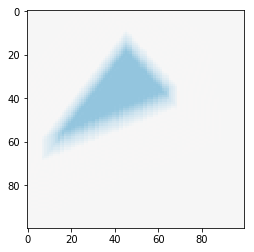

In [9]:
plt.imshow(np.mean(MXr,axis=2),vmin=-1,vmax=1,cmap='RdBu')